In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=1'

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html
from brax.training import normalization
import brax.jumpy as jp


import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController
from common import do_local_apg

from functools import partial

jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

1

In [2]:
episode_length = 200
action_repeat = 4
batch_size = jax.local_device_count()
noise_std = 0.1
apg_epochs = 100
normalize_observations=True

env_name = "reacher"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, auto_reset=False)
env = env_fn()

In [15]:
key = jax.random.PRNGKey(0)
key, reset_key = jax.random.split(key)
key, model_key = jax.random.split(reset_key)
key, train_key = jax.random.split(model_key)

In [16]:
policy = MlpController(env.observation_size,env.action_size,64)
normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations, num_leading_batch_dims=1)

init_states = env.reset(reset_key)
x0 = init_states.obs
h0 = jnp.zeros_like(init_states.obs)
policy_params = policy.init(model_key, h0, x0)

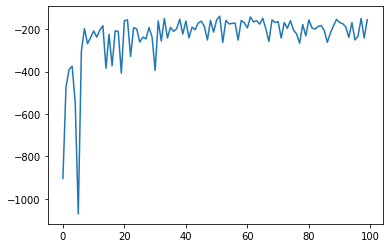

In [17]:
policy_params_trained, normalizer_params_all, rewards_lists = do_local_apg(apg_epochs, env_fn, policy.apply, normalizer_params, policy_params, train_key)
plt.plot(rewards_lists)

-11.914574414491653


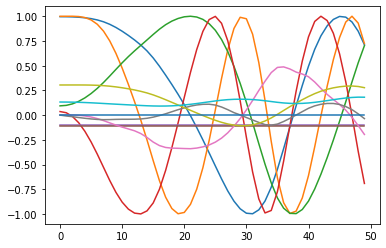

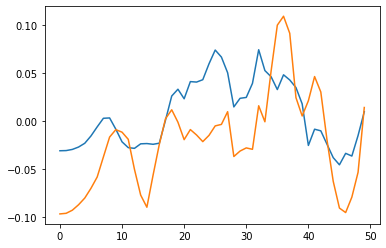

In [18]:
@jax.jit
def do_rnn_rollout(policy_params, normalizer_params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h, policy_params, normalizer_params  = carry

        normed_obs = obs_normalizer_apply_fn(normalizer_params, state.obs)
        h1 , actions = policy.apply(policy_params, h, normed_obs)
        nstate = env.step(state, actions)    
        #h1 = jax.lax.cond(nstate.done, lambda x: jnp.zeros_like(h1), lambda x: h1, None)
        return (jax.lax.stop_gradient(nstate), h1, policy_params, normalizer_params), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0, policy_params, normalizer_params),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states



key, reset_key = jax.random.split(key)
init_state = env.reset(reset_key)

(rewards, obs, acts, states) = do_rnn_rollout(policy_params_trained, normalizer_params, reset_key)
plt.plot(obs);
plt.figure()
plt.plot(acts);
print(sum(rewards))

In [12]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list)

In [ ]:
visualize